<a href="https://colab.research.google.com/github/CGnal/agos-ai-course/blob/master/day3/3_3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fi9mnhyj
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-fi9mnhyj
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=155802 sha256=f27b1b25775de49f4ee1e2e9921b63ceeeb66fa87e67125f11c9654aafe352c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-11b54s39/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
!pip install keract

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os
from tqdm.notebook import tqdm

In [4]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__

'2.7.0'

In [5]:
from keract import get_activations
from keract import display_activations

In [6]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# Caltech 256

## Load dataset 

In [7]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.transform import resize as imresize, rotate as imrotate
from keras.applications.inception_v3 import preprocess_input 

In [8]:
!gdown --id 1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK

Downloading...
From: https://drive.google.com/uc?id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK
To: /content/256_ObjectCategories.tar
100% 1.18G/1.18G [00:06<00:00, 182MB/s]


In [9]:
!tar -xf 256_ObjectCategories.tar

In [10]:
!ls

256_ObjectCategories  256_ObjectCategories.tar	sample_data


In [11]:
def loadBatchImages(path, samples_per_cat=None, val_fraction=0.1, nCat=None, min_samples_per_cat=200):
    catList = os.listdir(path)
    if nCat is not None:
      catList = catList[0:nCat]
    loadedImagesTrain = []
    loadedLabelsTrain = []
    loadedImagesVal = []
    loadedLabelsVal = []
    categories = []

    cat_id = -1
    for cat in tqdm(catList):
        if 'clutter' in cat:
          continue
        deepPath = path+cat+"/"
        imageList = os.listdir(deepPath)
        if len(imageList) < min_samples_per_cat:
          continue
        indx = 0
        categories.append(cat[4:])
        cat_id += 1
        if samples_per_cat is not None:
          imageList = imageList[0:samples_per_cat]
        for images in tqdm(imageList):
            n_val = int(len(imageList) * val_fraction)
            try:           
              img = load_img(deepPath + images)
            except:
              print(f'Could not load "{deepPath + images}". Skipping.')
              continue
            img = img_to_array(img)
            img = imresize(img, (150, 150))
            img = img.astype(np.ubyte)
            if indx < n_val:
                loadedLabelsVal.append(cat_id)
                loadedImagesVal.append(img)
            else:
                loadedLabelsTrain.append(cat_id)
                loadedImagesTrain.append(img)
            indx += 1
            

    return {k: cat for k, cat in enumerate(categories)}, loadedImagesTrain, loadedLabelsTrain, loadedImagesVal, loadedLabelsVal

In [12]:
path = "./256_ObjectCategories/"    
min_samples_per_cat = 200
 
categories, train_images_raw, train_labels_raw, test_images_raw, test_labels_raw = loadBatchImages(path, val_fraction=0.1, min_samples_per_cat=min_samples_per_cat)

train_images = np.asarray(preprocess_input(np.float64(train_images_raw)))
train_labels = keras.utils.to_categorical(train_labels_raw)
test_images = np.asarray(preprocess_input(np.float64(test_images_raw)))
test_labels = keras.utils.to_categorical(test_labels_raw)

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [13]:
nCat = len(categories)

In [14]:
train_images.shape, train_labels.shape

((4451, 150, 150, 3), (4451, 15))

In [15]:
test_images.shape, test_labels.shape

((488, 150, 150, 3), (488, 15))

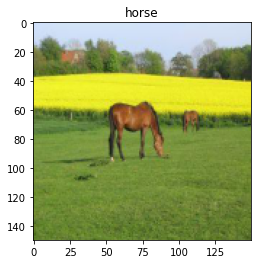

In [16]:
plt.imshow(train_images_raw[939])
plt.title(categories[train_labels_raw[939]])
plt.show()

## Define the model 

In [17]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,  # do not include the last classification dense layer
    weights="imagenet",
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
)

87924736/87910968 [==============================] - 1s 0us/step


In [18]:
base_model.trainable = False

In [19]:
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(nCat, activation='softmax', name='classifier')(x)
model = keras.Model(inputs, outputs)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Dense)          (None, 15)                30735     
                                                                 
Total params: 21,833,519
Trainable params: 30,735
Non-trainable params: 21,802,784
____________________________________________

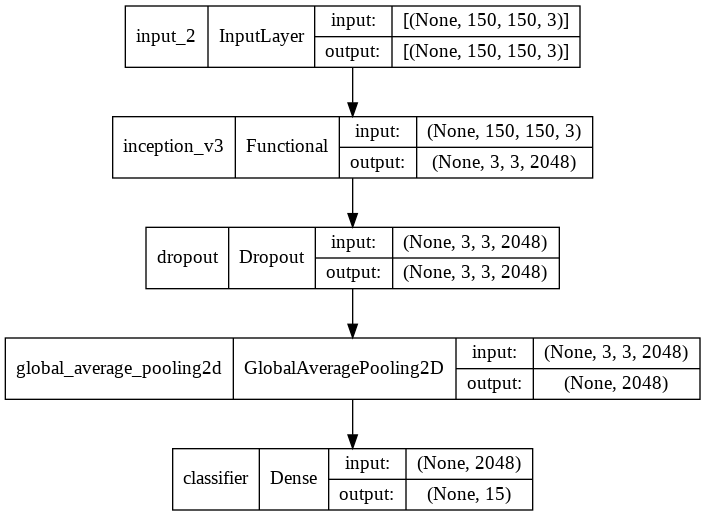

In [21]:
plot_model(model, show_shapes=True)

In [22]:
%%time

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                              verbose=1, patience=5)

history = model.fit(train_images, train_labels, epochs=20, batch_size=1000,
                    callbacks=[earlystopping],
                    shuffle=True, validation_split=0.1)

Epoch 1/20
5/5 [==============================] - 44s 4s/step - loss: 3.2685 - accuracy: 0.2005 - val_loss: 0.4118 - val_accuracy: 0.9193
Epoch 2/20
5/5 [==============================] - 8s 1s/step - loss: 1.5515 - accuracy: 0.5865 - val_loss: 0.3332 - val_accuracy: 0.9193
Epoch 3/20
5/5 [==============================] - 8s 1s/step - loss: 0.9151 - accuracy: 0.7223 - val_loss: 0.3072 - val_accuracy: 0.9148
Epoch 4/20
5/5 [==============================] - 8s 1s/step - loss: 0.7527 - accuracy: 0.7755 - val_loss: 0.1912 - val_accuracy: 0.9552
Epoch 5/20
5/5 [==============================] - 8s 1s/step - loss: 0.5468 - accuracy: 0.8282 - val_loss: 0.1518 - val_accuracy: 0.9552
Epoch 6/20
5/5 [==============================] - 8s 1s/step - loss: 0.5800 - accuracy: 0.8217 - val_loss: 0.1681 - val_accuracy: 0.9529
Epoch 7/20
5/5 [==============================] - 8s 1s/step - loss: 0.4857 - accuracy: 0.8479 - val_loss: 0.2417 - val_accuracy: 0.9484
Epoch 8/20
5/5 [========================

In [23]:
test_loss = model.evaluate(test_images, test_labels)
print("\nTest accuracy: ",test_loss[1])

16/16 [==============================] - 3s 135ms/step - loss: 0.3925 - accuracy: 0.8955

Test accuracy:  0.8954917788505554


In [24]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categories[predicted_label],
                                100*np.max(predictions_array),
                                categories[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(len(categories)))
  plt.yticks([])
  thisplot = plt.bar(range(len(categories)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

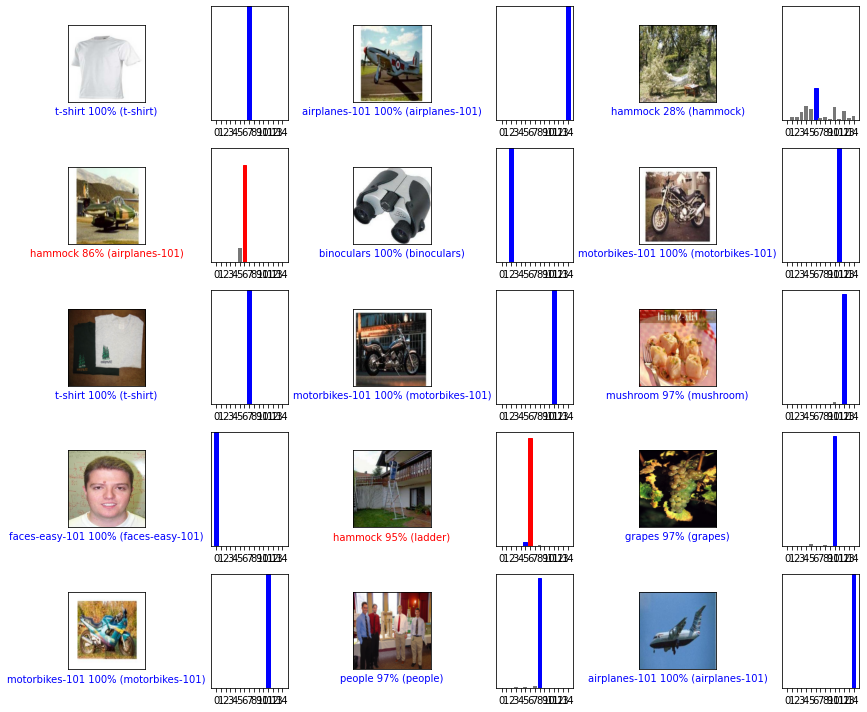

In [25]:
from numpy.random import randint

predictions = model.predict(test_images)
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
i = 0
for id_img in randint(0, test_images.shape[0], num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(id_img, predictions[id_img], test_labels, test_images_raw)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(id_img, predictions[id_img], test_labels)
  i += 1
plt.tight_layout()
plt.show()